In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/toronto-emotional-speech-set-tess


In [10]:
import os

dataset_path = "/kaggle/input/toronto-emotional-speech-set-tess"
listdir = os.listdir(dataset_path)
print(listdir)


['TESS Toronto emotional speech set data', 'tess toronto emotional speech set data']


In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, Bidirectional, LSTM, Attention
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import IPython.display as ipd

In [7]:
!pip install librosa audiomentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0


In [8]:
import librosa
import audiomentations as A
import soundfile as sf
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift
import seaborn as sns
import matplotlib.pyplot as plt

import torchaudio.transforms as T
import librosa.display


In [19]:
import re

i = len(listdir)
tess_file_paths = []
tess_labels = []
for j in range(i):
  tess_path = dataset_path + "/" + listdir[j]
  print(tess_path)

  for folder in os.listdir(tess_path):
      folder_path = os.path.join(tess_path, folder)
      # Only process folders that match the pattern like OAF_Fear
      if re.match(r"^[A-Z]{3}_[A-Za-z]+$", folder):
          label = folder.split('_')[1].lower()

          for file in os.listdir(folder_path):
              file_path = os.path.join(folder_path, file)
              tess_file_paths.append(file_path)
              tess_labels.append(label)

tess_data = pd.DataFrame({
    'paths' : tess_file_paths,
    'emotions' : tess_labels
})

## lets print first 5 rows of this dataset
print(tess_data.head())
print(tess_data.shape)
tess_data.tail()

/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data
/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data
                                               paths emotions
0  /kaggle/input/toronto-emotional-speech-set-tes...     fear
1  /kaggle/input/toronto-emotional-speech-set-tes...     fear
2  /kaggle/input/toronto-emotional-speech-set-tes...     fear
3  /kaggle/input/toronto-emotional-speech-set-tes...     fear
4  /kaggle/input/toronto-emotional-speech-set-tes...     fear
(2400, 2)


,paths,emotions
2395,/kaggle/input/toronto-emotional-speech-set-tes...,sad
2396,/kaggle/input/toronto-emotional-speech-set-tes...,sad
2397,/kaggle/input/toronto-emotional-speech-set-tes...,sad
2398,/kaggle/input/toronto-emotional-speech-set-tes...,sad
2399,/kaggle/input/toronto-emotional-speech-set-tes...,sad


In [25]:
!pip install tqdm

In [27]:
import tqdm
def audio_to_spectrogram(audio_path, emotion, save_root="spectrograms"):
    y, sr = librosa.load(audio_path, sr=22050)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Create save directory per emotion
    emotion_dir = os.path.join(save_root, emotion)
    os.makedirs(emotion_dir, exist_ok=True)

    # Save as PNG image
    base_name = os.path.basename(audio_path).replace('.wav', '.png')
    save_path = os.path.join(emotion_dir, base_name)

    plt.figure(figsize=(3, 3))
    librosa.display.specshow(mel_spec_db, sr=sr, cmap='magma')
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# 4. Process and save all audio files as spectrograms
for path, label in tqdm.tqdm(zip(tess_data['paths'], tess_data['emotions']), total=len(tess_data)):
    audio_to_spectrogram(path, label)

100%|██████████| 2400/2400 [05:07<00:00,  7.81it/s]


In [28]:
import shutil

src = '/content/spectrograms'
dst = '/content/drive/MyDrive/spectrograms'

shutil.move(src, dst)


'/content/drive/MyDrive/spectrograms'

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
# Path where spectrogram images are stored by emotion folders
data_dir = "/content/drive/MyDrive/spectrograms"

# Image size
img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80/20 train/val split
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Found 1920 images belonging to 6 classes.
Found 480 images belonging to 6 classes.
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4151 - loss: 1.4508 - val_accuracy: 0.9875 - val_loss: 0.1562
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9789 - loss: 0.0774 - val_accuracy: 0.9875 - val_loss: 0.0307
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9942 - loss: 0.0215 - val_accuracy: 0.9958 - val_loss: 0.0106
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9950 - loss: 0.0153 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.9979 - val_loss: 0.0050
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9961 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9967 - loss: 0.0083 - val_accuracy: 0.9937 - val_loss: 0.0281
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


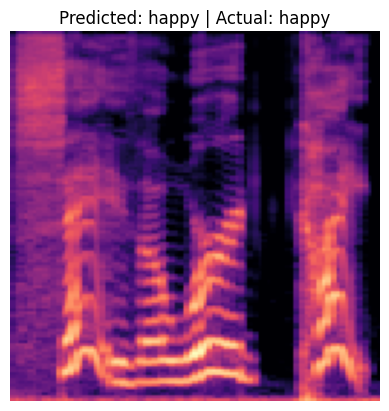

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Get class labels (emotion names)
class_labels = list(val_generator.class_indices.keys())

# Pick a random batch and image from the validation set
batch_index = random.randint(0, len(val_generator) - 1)
images, labels = val_generator[batch_index]

# Pick a random image from the batch
img_index = random.randint(0, len(images) - 1)
image = images[img_index]
true_label = np.argmax(labels[img_index])

# Predict using the model
pred = model.predict(np.expand_dims(image, axis=0))  # shape (1, 128, 128, 3)
pred_label = np.argmax(pred[0])

# Display image and prediction
plt.imshow(image)
plt.title(f"Predicted: {class_labels[pred_label]} | Actual: {class_labels[true_label]}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━

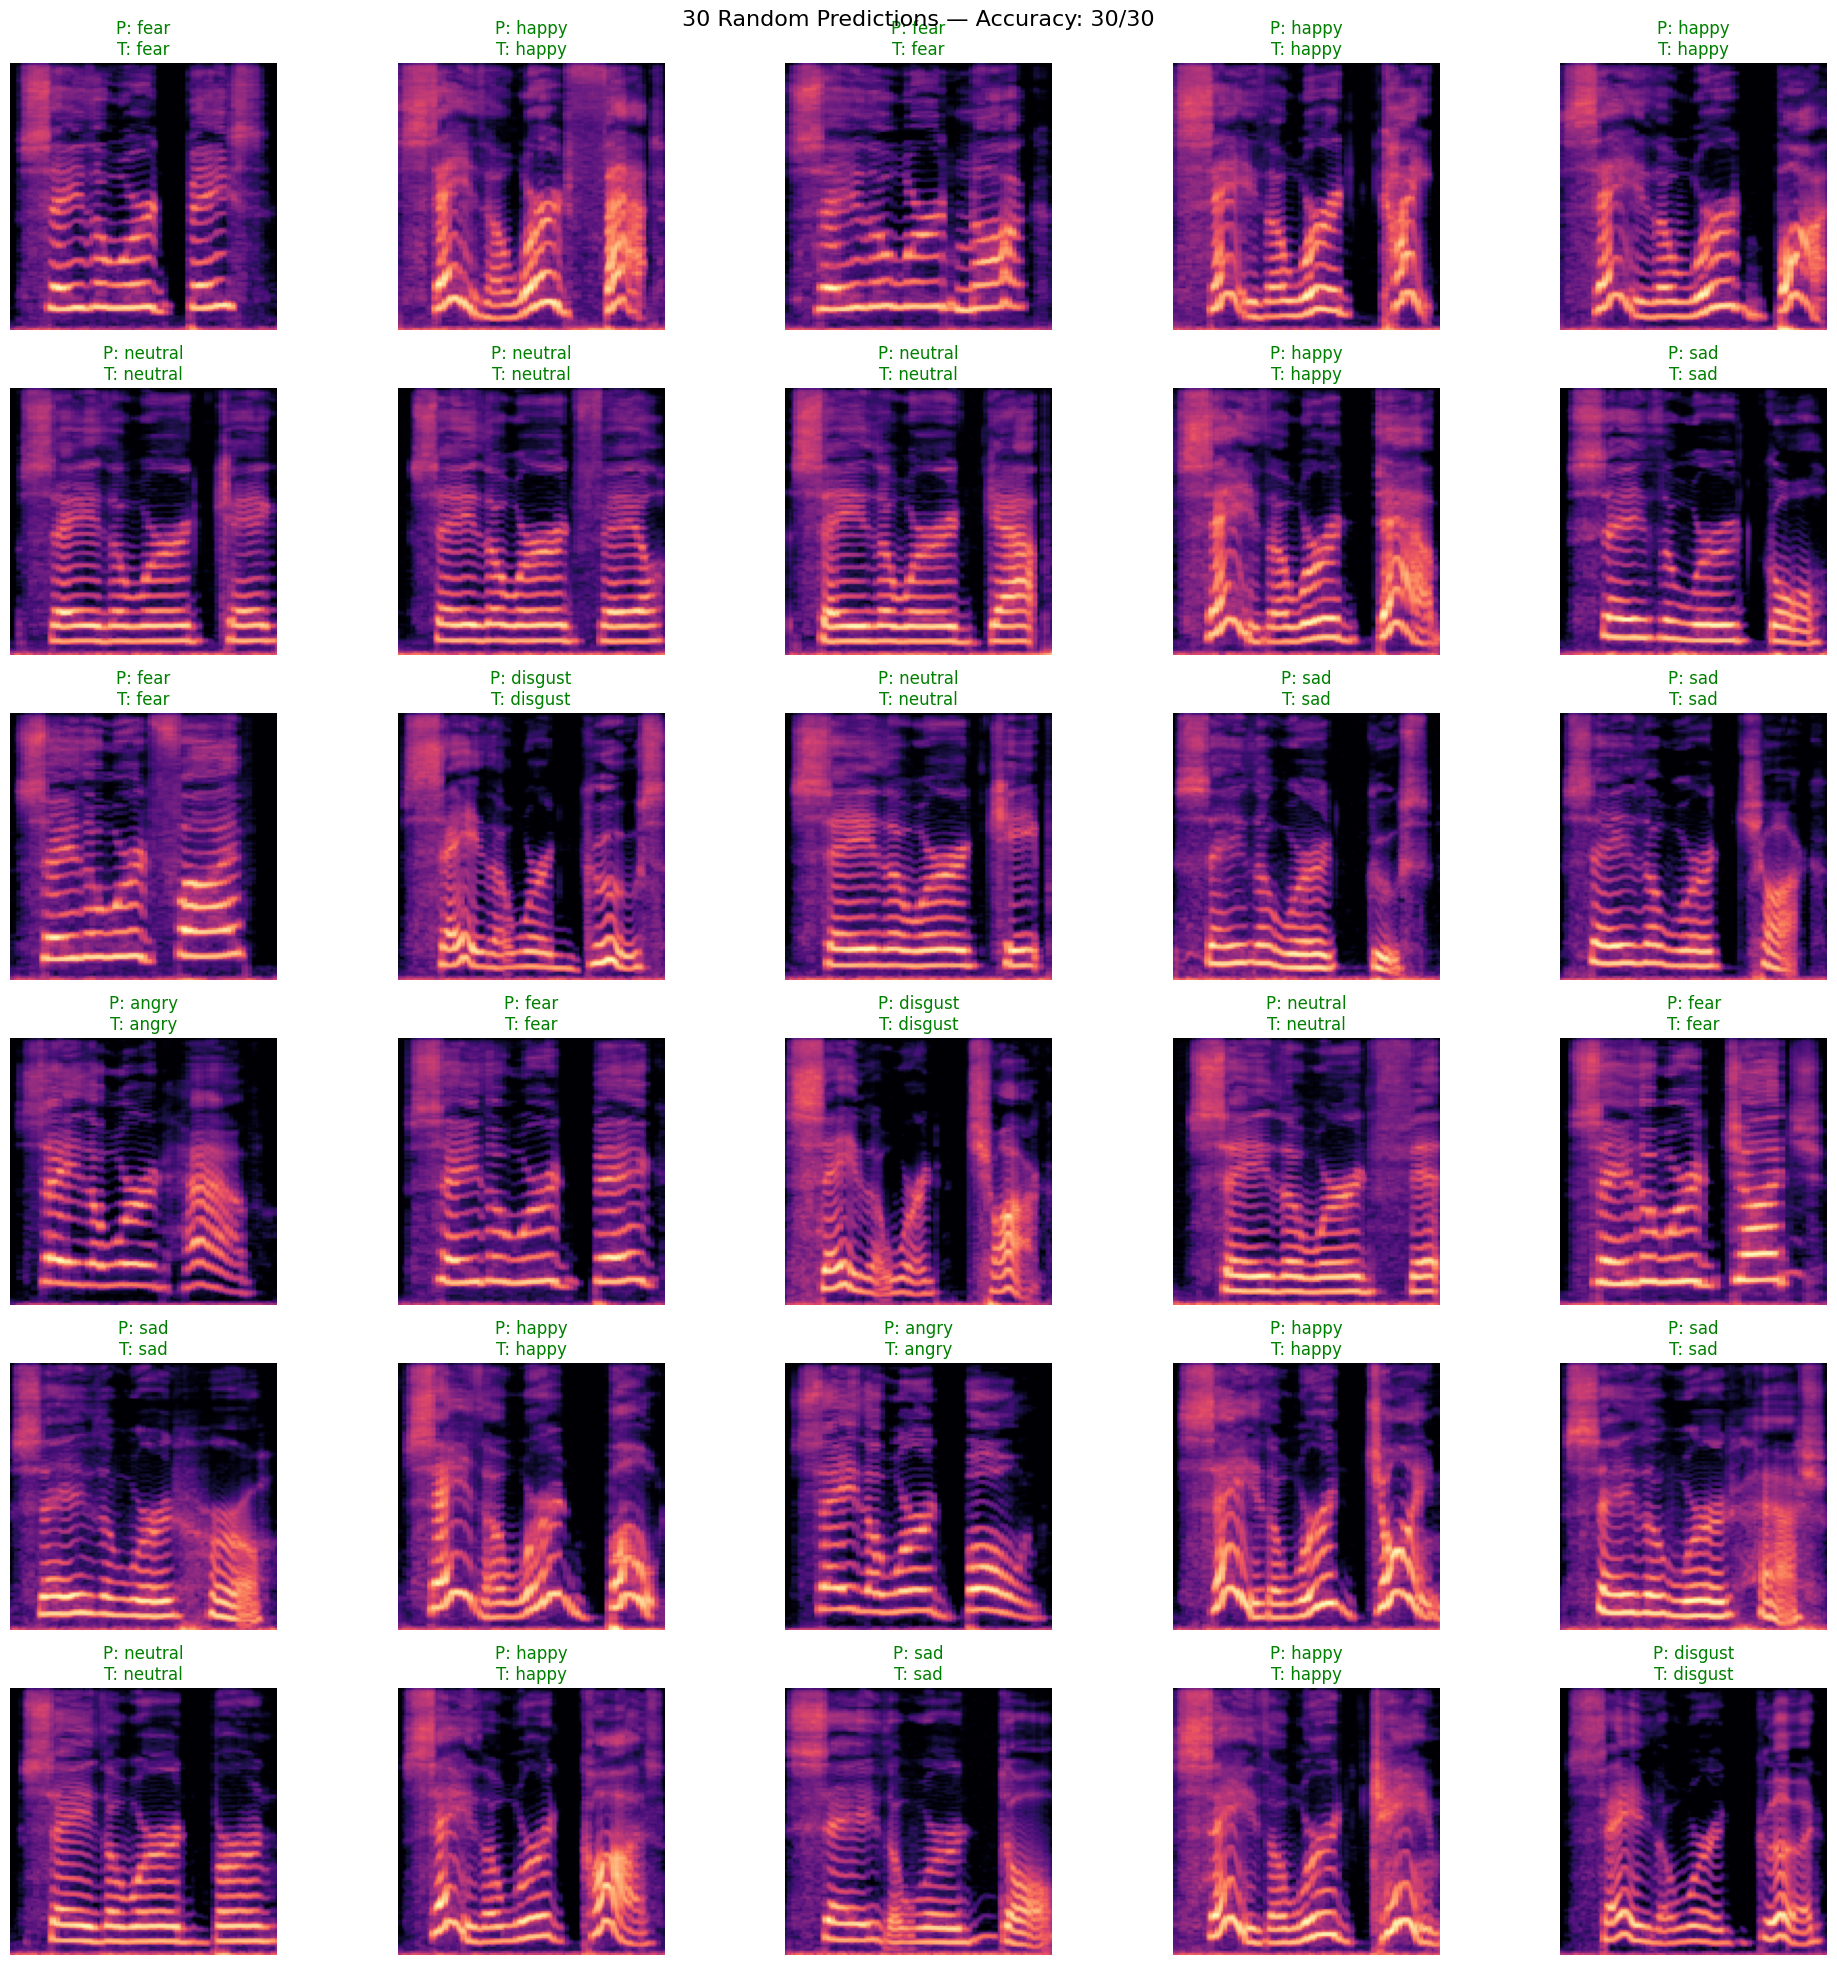

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import random

class_labels = list(val_generator.class_indices.keys())
total_samples = 30  # Number of random samples to test

# Collect all validation data in memory (optional but faster for random access)
val_images = []
val_labels = []

for i in range(len(val_generator)):
    imgs, lbls = val_generator[i]
    val_images.extend(imgs)
    val_labels.extend(lbls)

# Select 30 random indices
random_indices = random.sample(range(len(val_images)), total_samples)

# Loop through 30 samples and predict
correct = 0

plt.figure(figsize=(20, 20))
for idx, i in enumerate(random_indices):
    img = val_images[i]
    label = np.argmax(val_labels[i])
    pred = model.predict(np.expand_dims(img, axis=0))
    pred_label = np.argmax(pred[0])

    is_correct = pred_label == label
    if is_correct:
        correct += 1

    plt.subplot(6, 5, idx + 1)  # 6x5 grid = 30
    plt.imshow(img)
    plt.axis('off')
    color = 'green' if is_correct else 'red'
    plt.title(f"P: {class_labels[pred_label]}\nT: {class_labels[label]}", color=color)

plt.suptitle(f"30 Random Predictions — Accuracy: {correct}/30", fontsize=16)
plt.tight_layout()
plt.show()


In [38]:
model.save('/content/drive/MyDrive/emotion_cnn_model.h5')

In [39]:
model.save('/content/drive/MyDrive/emotion_cnn_model.keras')
